In [2]:
#@title import
import numpy as np
import math
import time
import pyfolio
import gym
from gym.utils import seeding
from gym import spaces
import numpy as np
import random
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import riskfolio as rp
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from sb3_contrib import TRPO
from sklearn import preprocessing

/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/python_ml/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Text(0.5, 0, 'Time (Years)')

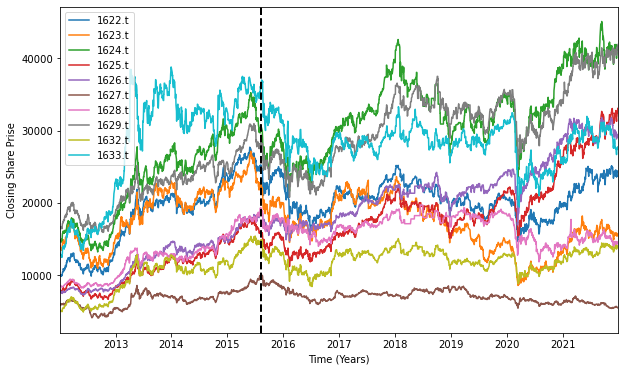

In [4]:
#@title Preprocessing 米国上位10

tickers =  ["1622.t","1623.t","1624.t","1625.t","1626.t","1627.t","1628.t","1629.t","1632.t","1633.t"]
df = pdr.DataReader([tickers][0], data_source='yahoo',start='2012-01-01', end="2022-01-01")
mm = preprocessing.MinMaxScaler()
data = df.copy()
# we copy the neighbour values to NaN entries
data['Adj Close'] = data['Adj Close'].ffill()
df = df.bfill(axis=1)

data['Adj Close'] = data['Adj Close'].bfill()
df = df.bfill(axis=1)
sentiment=pd.read_csv("news_sentiment_data.csv",parse_dates=["date"],index_col=["date"])
sentiment["News Sentiment"]=mm.fit_transform(sentiment)
data = data['Adj Close']
data=pd.merge(data,sentiment, left_index=True,right_on="date")
#data=pd.concat([data,df["Volume"]],axis=1)
#@title Define the start-end dates for the training and testing data
train_pct = 0.8026
samples_train = int(train_pct*len(data))
data_train = data[:samples_train]
data_test = data[samples_train:]

#@title *Visualization*
plt.rcParams["figure.figsize"] = (10,6)
for i in tickers:
    plt.plot(data[i], label=i)

#only one line may be specified; full height
plt.axvline(pd.to_datetime('2015-08-10'), color='black', linestyle='--', lw=2)
plt.legend()
plt.margins(x=0)
plt.ylabel("Closing Share Prise")
plt.xlabel("Time (Years)")

In [25]:
#@title Deep RL code
# 10 shares per trade-share
HMAX_NORMALIZE = 10
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE= 0
# transaction fee: 1/100 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.01
# Number of stocks we manege
NUMBER_OF_STOCKS=10
NUMBER_OF_VARIABLE=11

class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, day=0, initial=True):
        
        self.df = df
        self.day = day
        self.initial = initial
        # Total number of stocks in our portfolio
        self.stock_dim = NUMBER_OF_STOCKS  
        self.vari_num = NUMBER_OF_VARIABLE      
        # 行動空間
        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = -1, high = 1, shape = (self.stock_dim,)) 
        # 観測空間
        # Shape = 1+8+8: [Current Balance]+[prices]+[owned shares] +[Others]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (2*self.stock_dim+1+self.vari_num,))
        # load data from a pandas dataframe
        self.data = self.df.iloc[self.day,:-self.vari_num]
        self.vari = self.df.iloc[self.day,-self.vari_num:]
        self.terminal = False
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + self.data.values.tolist() + [0]*self.stock_dim + self.vari.values.tolist()
        # initialize reward
        self.reward = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]    
        self._seed(0) 

    def _sell_stock(self, index, action):
        # we need to round since we cannot buy half stock
        action = np.floor(action)
        if self.state[index+self.stock_dim+1] > 0:
        # update balance = price stock * # of stock to sell * fee
            self.state[0] += self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * (1- TRANSACTION_FEE_PERCENT)
            self.state[index+self.stock_dim+1] -= min(abs(action), self.state[index+self.stock_dim+1])
        else:
            pass
    def _buy_stock(self, index, action):
        # we need to round since we cannot buy half stock
        action = np.floor(action)
        # update balance = price stock * # of stock to buy * fee 
        self.state[0] -= self.state[index+1] * action * (1+ TRANSACTION_FEE_PERCENT)
        self.state[index+self.stock_dim+1] += action
        
        

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1
        if self.terminal:
            return self.state, self.reward, self.terminal,{}
        else:       
            actions = actions * HMAX_NORMALIZE
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self._sell_stock(index, actions[index])
            for index in buy_index:
                self._buy_stock(index, actions[index])
    
            self.day += 1
            self.data = self.df.iloc[self.day,:-self.vari_num]
            self.vari = self.df.iloc[self.day,-self.vari_num:]
            #load next state i.e. the new value of the stocks
            self.state =  [self.state[0]] + self.data.values.tolist() + \
                            list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)])+self.vari.values.tolist()
            

            end_total_asset = self.state[0] + \
                            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
        
            self.reward = end_total_asset - begin_total_asset            
            weights = self.normalization(np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            self.actions_memory.append(weights.tolist())
            self.reward = self.reward

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        self.day = 0
        self.data = self.df.iloc[self.day,:-self.vari_num]
        self.vari = self.df.iloc[self.day,-self.vari_num:]
        self.terminal = False 
        
        # memorize all the total balance change
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + self.data.values.tolist() + [0]*self.stock_dim + self.vari.values.tolist()
        
        self._seed(0) 
        return self.state
    
    def normalization(self, actions):
        output = actions/(np.sum(actions)+1e-15)
        return output

    def save_action_memory(self):
        return self.actions_memory
    
    def render(self, mode='human',close=False):
        print("render")
        return self.state
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
def train(algo, policy , env_train, timesteps, seed=None, save=True):
    start = time.time()   
    if algo == "PPO":
        model = PPO(policy, env_train, verbose=0, seed=seed)
    elif algo =="A2C":
        model = A2C(policy, env_train, verbose=0, seed=seed)
    elif algo =="DDPG":
        model = DDPG(policy, env_train, verbose=0, seed=seed)
    elif algo =="SAC":
        model = SAC(policy, env_train, verbose=0, seed=seed)  
    elif algo =="TD3":
        model = TD3(policy, env_train, verbose=0, seed=seed)
    elif algo =="TRPO":
        model = TRPO(policy, env_train, verbose=0, seed=seed)  
    model.learn(total_timesteps=timesteps)
    end = time.time() 
    if save == True:
        model.save("results/"+algo+"_"+str(timesteps)+"_model")
    print("Training time: ", (end-start)/60," minutes")
    return model


def DRL_prediction(model, data, env, obs):
    actions_memory = []
    model.set_random_seed(10)
    for i in range(len(data.index.unique())):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        if i == (len(data.index.unique()) - 2):
            actions_memory = env.env_method(method_name="save_action_memory")
    return actions_memory[0]

In [26]:
#@title setting
rebalance_period = 1
re_df = data.iloc[::rebalance_period, :]
train_re_df = data_train.iloc[::rebalance_period, :]
test_re_df = data_test.iloc[::rebalance_period, :]
timesteps = 25000
runs = 10
policy = "MlpPolicy"
length = test_re_df.shape[0]
stocks = test_re_df.shape[1]-NUMBER_OF_VARIABLE
test_re_df.to_csv("test_topix_10.csv")

def RUN(runs, length, stocks, algo):
    Cumulative_returns_daily = np.zeros([runs, length])
    portfolio_weights = np.zeros([runs, length, stocks])
    i=0
    cont=0
    while (i<runs): 
        train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
        model = train(algo, policy, train_env, timesteps, seed=cont, save=False)
        test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
        test_obs = test_env.reset()
        portfolio_weights[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
        check = np.sum(portfolio_weights[i]) 
        cont = cont +1
        if check != length:
         continue

        return_stocks = test_re_df.iloc[:,:-NUMBER_OF_VARIABLE].pct_change()
        return_stocks = np.sum(return_stocks.multiply(portfolio_weights[i]),axis=1)
        Cumulative_returns_daily[i] = (1+return_stocks).cumprod()
        i = i+1
    portfolio_weights_ = np.mean(np.array(portfolio_weights),axis=0)
    return pd.DataFrame (portfolio_weights_, index = test_re_df.iloc[:,:-NUMBER_OF_VARIABLE].index, columns = tickers)

In [7]:
print("PPO")
df_ppo = RUN(runs, length, stocks, "PPO")
print("A2C")
df_a2c = RUN(runs, length, stocks, "PPO")
print("TRPO")
df_trpo = RUN(runs, length, stocks, "TRPO")
df_on=(df_ppo+df_trpo+df_a2c)/3
df_on.to_csv("on-policy-us10.csv")
print("DDPG")
df_ddpg = RUN(runs, length, stocks, "DDPG")
print("SAC")
df_sac = RUN(runs, length, stocks, "SAC")
print("TD3")
df_td3 = RUN(runs, length, stocks, "TD3")
df_off=(df_ddpg+df_sac+df_td3)/3
df_off.to_csv("off-policy-us10.csv")

PPO
Training time:  0.2380422870318095  minutes
Training time:  0.2179340640703837  minutes
Training time:  0.21740631659825643  minutes
Training time:  0.21681611935297648  minutes
Training time:  0.21642598311106365  minutes
Training time:  0.21611923376719158  minutes
Training time:  0.22542274792989095  minutes
Training time:  0.21438739697138467  minutes
Training time:  0.21436006625493367  minutes
Training time:  0.2142072836558024  minutes
A2C
Training time:  0.21464840173721314  minutes
Training time:  0.2148735483487447  minutes
Training time:  0.21541943550109863  minutes
Training time:  0.21484428246815998  minutes
Training time:  0.21603265603383381  minutes
Training time:  0.21587073405583698  minutes
Training time:  0.21584326426188152  minutes
Training time:  0.216286301612854  minutes
Training time:  0.21609803438186645  minutes
Training time:  0.2171076814333598  minutes
TRPO
Training time:  0.16789633830388387  minutes
Training time:  0.1675370176633199  minutes
Train

# 米国上位5

Text(0.5, 0, 'Time (Years)')

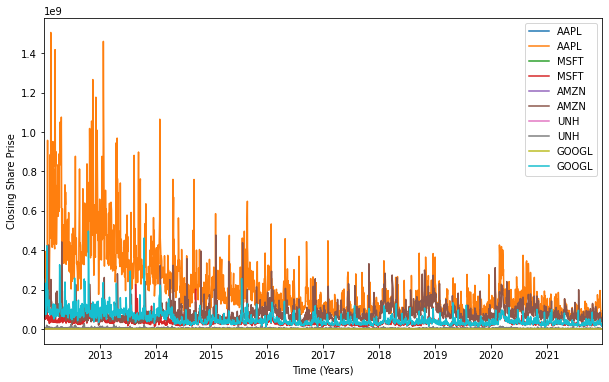

In [12]:
#@title Preprocessing

tickers =  ["AAPL","MSFT","AMZN","UNH","GOOGL"]
df = pdr.DataReader([tickers][0], data_source='yahoo',start='2012-01-01', end="2022-01-01")
mm = preprocessing.MinMaxScaler()
data = df.copy()
# we copy the neighbour values to NaN entries
data['Adj Close'] = data['Adj Close'].ffill()
df = df.bfill(axis=1)

data['Adj Close'] = data['Adj Close'].bfill()
df = df.bfill(axis=1)
sentiment=pd.read_csv("news_sentiment_data.csv",parse_dates=["date"],index_col=["date"])
sentiment["News Sentiment"]=mm.fit_transform(sentiment)
data = data['Adj Close']
data=pd.merge(data,sentiment, left_index=True,right_on="date")
data=pd.concat([data,df["Volume"]],axis=1)
#@title Define the start-end dates for the training and testing data
train_pct = 0.8026
samples_train = int(train_pct*len(data))
data_train = data[:samples_train]
data_test = data[samples_train:]

#@title *Visualization*
plt.rcParams["figure.figsize"] = (10,6)
for i in tickers:
    plt.plot(data[i], label=i)

# only one line may be specified; full height
#plt.axvline(pd.to_datetime('2015-08-10'), color='black', linestyle='--', lw=2)
plt.legend()
plt.margins(x=0)
plt.ylabel("Closing Share Prise")
plt.xlabel("Time (Years)")

In [14]:
#@title setting
NUMBER_OF_STOCKS=5
NUMBER_OF_VARIABLE=6
rebalance_period = 1
re_df = data.iloc[::rebalance_period, :]
train_re_df = data_train.iloc[::rebalance_period, :]
test_re_df = data_test.iloc[::rebalance_period, :]
timesteps = 25000
runs = 10
policy = "MlpPolicy"
length = test_re_df.shape[0]
stocks = test_re_df.shape[1]-NUMBER_OF_VARIABLE
test_re_df.to_csv("test_us5.csv")


print("PPO")
df_ppo = RUN(runs, length, stocks, "PPO")
print("A2C")
df_a2c = RUN(runs, length, stocks, "PPO")
print("TRPO")
df_trpo = RUN(runs, length, stocks, "TRPO")
df_on=(df_ppo+df_trpo+df_a2c)/3
df_on.to_csv("on-policy-us5.csv")
print("DDPG")
df_ddpg = RUN(runs, length, stocks, "DDPG")
print("SAC")
df_sac = RUN(runs, length, stocks, "SAC")
print("TD3")
df_td3 = RUN(runs, length, stocks, "TD3")
df_off=(df_ddpg+df_sac+df_td3)/3
df_off.to_csv("off-policy-us5.csv")

PPO
Training time:  0.21842286586761475  minutes
Training time:  0.21457835038503012  minutes
Training time:  0.2170778473218282  minutes
Training time:  0.21175907055536905  minutes
Training time:  0.21213415066401164  minutes
Training time:  0.21225845019022624  minutes
Training time:  0.21374919811884563  minutes
Training time:  0.2120379646619161  minutes
Training time:  0.2131896694501241  minutes
Training time:  0.21034247080485027  minutes
A2C
Training time:  0.21323750019073487  minutes
Training time:  0.21232381264368694  minutes
Training time:  0.21521396636962892  minutes
Training time:  0.21359399557113648  minutes
Training time:  0.21526503165562946  minutes
Training time:  0.21218119859695433  minutes
Training time:  0.21537450154622395  minutes
Training time:  0.21653552850087485  minutes
Training time:  0.21417401631673177  minutes
Training time:  0.21120878060658774  minutes
TRPO
Training time:  0.16413938601811726  minutes
Training time:  0.16419875224431354  minutes


# S&P sector index

Text(0.5, 0, 'Time (Years)')

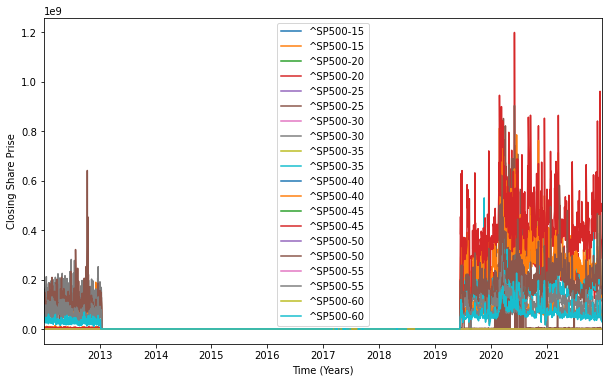

In [23]:
#@title Preprocessing

tickers =  ["^SP500-15","^SP500-20","^SP500-25","^SP500-30","^SP500-35","^SP500-40","^SP500-45","^SP500-50","^SP500-55","^SP500-60"]
df = pdr.DataReader([tickers][0], data_source='yahoo',start='2012-01-01', end="2022-01-01")
mm = preprocessing.MinMaxScaler()
data = df.copy()
# we copy the neighbour values to NaN entries
data['Adj Close'] = data['Adj Close'].ffill()
df = df.bfill(axis=1)

data['Adj Close'] = data['Adj Close'].bfill()
df = df.bfill(axis=1)
sentiment=pd.read_csv("news_sentiment_data.csv",parse_dates=["date"],index_col=["date"])
sentiment["News Sentiment"]=mm.fit_transform(sentiment)
data = data['Adj Close']
data=pd.merge(data,sentiment, left_index=True,right_on="date")
data=pd.concat([data,df["Volume"]],axis=1)
#@title Define the start-end dates for the training and testing data
train_pct = 0.8026
samples_train = int(train_pct*len(data))
data_train = data[:samples_train]
data_test = data[samples_train:]

#@title *Visualization*
plt.rcParams["figure.figsize"] = (10,6)
for i in tickers:
    plt.plot(data[i], label=i)

# only one line may be specified; full height
#plt.axvline(pd.to_datetime('2015-08-10'), color='black', linestyle='--', lw=2)
plt.legend()
plt.margins(x=0)
plt.ylabel("Closing Share Prise")
plt.xlabel("Time (Years)")

In [24]:
#@title setting
NUMBER_OF_STOCKS=10
NUMBER_OF_VARIABLE=11
rebalance_period = 1
re_df = data.iloc[::rebalance_period, :]
train_re_df = data_train.iloc[::rebalance_period, :]
test_re_df = data_test.iloc[::rebalance_period, :]
timesteps = 25000
runs = 10
policy = "MlpPolicy"
length = test_re_df.shape[0]
stocks = test_re_df.shape[1]-NUMBER_OF_VARIABLE
test_re_df.to_csv("test_topix_sp10.csv")

print("PPO")
df_ppo = RUN(runs, length, stocks, "PPO")
print("A2C")
df_a2c = RUN(runs, length, stocks, "PPO")
print("TRPO")
df_trpo = RUN(runs, length, stocks, "TRPO")
df_on=(df_ppo+df_trpo+df_a2c)/3
df_on.to_csv("on-policy-sp10.csv")
print("DDPG")
df_ddpg = RUN(runs, length, stocks, "DDPG")
print("SAC")
df_sac = RUN(runs, length, stocks, "SAC")
print("TD3")
df_td3 = RUN(runs, length, stocks, "TD3")
df_off=(df_ddpg+df_sac+df_td3)/3
df_off.to_csv("off-policy-sp10.csv")

PPO


ValueError: Expected parameter loc (Tensor of shape (1, 10)) of distribution Normal(loc: torch.Size([1, 10]), scale: torch.Size([1, 10])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

# TOPIX業種別

In [ ]:
# #@title Preprocessing

# tickers =  ["1622.t","1623.t","1624.t","1625.t","1626.t","1627.t","1628.t","1629.t","1632.t","1633.t"]
# df = pdr.DataReader([tickers][0], data_source='yahoo',start='2012-01-01', end="2022-01-01")

# data = df.copy()
# # we copy the neighbour values to NaN entries
# data['Adj Close'] = data['Adj Close'].ffill()
# df = df.bfill(axis=1)

# data['Adj Close'] = data['Adj Close'].bfill()
# df = df.bfill(axis=1)

# data = data['Adj Close']
# #@title Define the start-end dates for the training and testing data
# train_pct = 0.8026
# samples_train = int(train_pct*len(data))
# data_train = data[:samples_train]
# data_test = data[samples_train:]

# #@title *Visualization*
# plt.rcParams["figure.figsize"] = (10,6)
# for i in tickers:
#     plt.plot(data[i], label=i)

# # only one line may be specified; full height
# #plt.axvline(pd.to_datetime('2015-08-10'), color='black', linestyle='--', lw=2)
# plt.legend()
# plt.margins(x=0)
# plt.ylabel("Closing Share Prise")
# plt.xlabel("Time (Years)")

# rebalance_period = 1
# re_df = data.iloc[::rebalance_period, :]
# train_re_df = data_train.iloc[::rebalance_period, :]
# test_re_df = data_test.iloc[::rebalance_period, :]
# timesteps = 25000
# runs = 10
# policy = "MlpPolicy"
# length = test_re_df.shape[0]
# stocks = test_re_df.shape[1]
# test_re_df.to_csv("test_topix_sec.csv")
# print("PPO")
# df_ppo = RUN(runs, length, stocks, "PPO")
# print("A2C")
# df_a2c = RUN(runs, length, stocks, "PPO")
# print("TRPO")
# df_trpo = RUN(runs, length, stocks, "TRPO")
# df_on=(df_ppo+df_trpo+df_a2c)/3
# df_on.to_csv("on-policy-topix-sec.csv")
# print("DDPG")
# df_ddpg = RUN(runs, length, stocks, "DDPG")
# print("SAC")
# df_sac = RUN(runs, length, stocks, "SAC")
# print("TD3")
# df_td3 = RUN(runs, length, stocks, "TD3")
# df_off=(df_ddpg+df_sac+df_td3)/3
# df_off.to_csv("off-policy-topix-sec.csv")

# TOPIX(5&10)

In [ ]:
# #@title Preprocessing
# tickers =  ['7202.t', '9432.t', '6861.t', '6758.t', '9984.t', '9433.t', '4568.t', '8306.t', '9983.t','7974.t']
# df = pdr.DataReader([tickers][0], data_source='yahoo',start='2012-01-01', end="2022-01-01")

# data = df.copy()
# # we copy the neighbour values to NaN entries
# data['Adj Close'] = data['Adj Close'].ffill()
# df = df.bfill(axis=1)

# data['Adj Close'] = data['Adj Close'].bfill()
# df = df.bfill(axis=1)

# data = data['Adj Close']
# #@title Define the start-end dates for the training and testing data
# train_pct = 0.8026
# samples_train = int(train_pct*len(data))
# data_train = data[:samples_train]
# data_test = data[samples_train:]
# print("DDPG")
# df_ppo = RUN(runs, length, stocks, "DDPG")
# print("A2C")
# df_a2c = RUN(runs, length, stocks, "PPO")
# print("TRPO")
# df_trpo = RUN(runs, length, stocks, "TRPO")
# df_on=(df_ppo+df_trpo+df_a2c)/3
# df_on.to_csv("on-policy-topix10.csv")
# print("DDPG")
# df_ddpg = RUN(runs, length, stocks, "DDPG")
# print("SAC")
# df_sac = RUN(runs, length, stocks, "SAC")
# print("TD3")
# df_td3 = RUN(runs, length, stocks, "TD3")
# df_off=(df_ddpg+df_sac+df_td3)/3
# df_off.to_csv("off-policy-topix10.csv")
#-------------------------------------------------------------------------------------------------------------------------
# #@title Preprocessing
# tickers =  ['7202.t', '9432.t', '6861.t', '6758.t', '9984.t']
# df = pdr.DataReader([tickers][0], data_source='yahoo',start='2012-01-01', end="2022-01-01")

# data = df.copy()
# # we copy the neighbour values to NaN entries
# data['Adj Close'] = data['Adj Close'].ffill()
# df = df.bfill(axis=1)

# data['Adj Close'] = data['Adj Close'].bfill()
# df = df.bfill(axis=1)

# data = data['Adj Close']
# #@title Define the start-end dates for the training and testing data
# train_pct = 0.80
# samples_train = int(train_pct*len(data))
# data_train = data[:samples_train]
# data_test = data[samples_train:]

# #@title *Visualization*
# plt.rcParams["figure.figsize"] = (10,6)
# for i in tickers:
#     plt.plot(data[i], label=i)
# plt.legend()
# plt.margins(x=0)
# plt.ylabel("Closing Share Prise")
# plt.xlabel("Time (Years)")
# #@title setting
# rebalance_period = 1
# re_df = data.iloc[::rebalance_period, :]
# train_re_df = data_train.iloc[::rebalance_period, :]
# test_re_df = data_test.iloc[::rebalance_period, :]
# timesteps = 25000
# runs = 10
# policy = "MlpPolicy"
# length = test_re_df.shape[0]
# stocks = test_re_df.shape[1]
# test_re_df.to_csv("test_topix_5.csv")

# print("PPO")
# df_ppo = RUN(runs, length, stocks, "PPO")
# print("A2C")
# df_a2c = RUN(runs, length, stocks, "PPO")
# print("TRPO")
# df_trpo = RUN(runs, length, stocks, "TRPO")
# df_on=(df_ppo+df_trpo+df_a2c)/3
# df_on.to_csv("on-policy-topix5.csv")
# print("DDPG")
# df_ddpg = RUN(runs, length, stocks, "DDPG")
# print("SAC")
# df_sac = RUN(runs, length, stocks, "SAC")
# print("TD3")
# df_td3 = RUN(runs, length, stocks, "TD3")
# df_off=(df_ddpg+df_sac+df_td3)/3
# df_off.to_csv("off-policy-topix5.csv")